In [ ]:
# default_exp calibrate

# Calibration Procedure

> summary

Every OpenHSI camera is unique and requires calibration before use. This module provides the abstractions to create the calibration data which are then used in operation. 


In [ ]:
#hide

# documentation extraction for class methods
from nbdev.showdoc import *

# unit tests using test_eq(...)
from fastcore.test import *

# monkey patching class methods using @patch
from fastcore.foundation import *
from fastcore.foundation import patch

# imitation of Julia's multiple dispatch using @typedispatch
from fastcore.dispatch import typedispatch

# bring forth **kwargs from an inherited class for documentation
from fastcore.meta import delegates

In [ ]:
#export

from fastcore.foundation import patch
from fastcore.meta import delegates
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d
from PIL import Image
from scipy.signal import decimate, medfilt
import holoviews as hv
hv.extension('bokeh',logo=False)
from fastprogress.fastprogress import master_bar, progress_bar

from scipy.signal import find_peaks, savgol_filter
from scipy.optimize import curve_fit
from scipy import interpolate
from functools import reduce

from typing import Iterable, Union, Callable, List, TypeVar, Generic, Tuple, Optional
import datetime
import json
import pickle

In [ ]:
#export

from openhsi.data import *
from openhsi.capture import *
from openhsi.cameras import *

In [ ]:

"""
cam_prop.settings["longitude"] = -17.7
cam_prop.settings["latitude"] = 146.1
cam_prop.settings["datetime_str"] = "2021-05-26 03:26"
cam_prop.settings["altitude"] = 0.12
cam_prop.settings["radiosonde_station_num"] = 94299
cam_prop.settings["radiosonde_region"] = "pac"
cam_prop.settings["sixs_path"] = "assets/sixsV1.1"
"""

'\ncam_prop.settings["longitude"] = -17.7\ncam_prop.settings["latitude"] = 146.1\ncam_prop.settings["datetime_str"] = "2021-05-26 03:26"\ncam_prop.settings["altitude"] = 0.12\ncam_prop.settings["radiosonde_station_num"] = 94299\ncam_prop.settings["radiosonde_region"] = "pac"\ncam_prop.settings["sixs_path"] = "assets/sixsV1.1"\n'

In [ ]:
HgAr_lines = np.array([404.656,407.783,435.833,546.074,576.960,579.066,696.543,706.722,727.294,738.393,
                           750.387,763.511,772.376,794.818,800.616,811.531,826.452,842.465,912.297])

def sum_gaussians(x:"indices np.array", 
                    *args:"amplitude, peak position, peak width, constant") -> np.array:
    split = len(args)//3
    A   = args[0:split]         # amplitude
    mu  = args[split:2*split]   # peak position
    sigma = args[split*2:-1]    # peak stdev
    c   = args[-1]              # offset
    return np.array( [A[i] * np.exp( - np.square( (x - mu[i])/sigma[i] ) ) 
                        for i in range(len(A))] ).sum(axis=0) + c

In [ ]:
#export

class SettingsBuilderMixin():
        
    def retake_flat_field(self, show:bool = False):
        self.start_cam()
        self.calibration["flat_field_pic"] = self.get_img()
        self.stop_cam()
        
        if show:
            return hv.Image(self.calibration["flat_field_pic"], bounds=(0,0,*self.calibration["flat_field_pic"].shape)).opts(
                    xlabel="wavelength index",ylabel="cross-track",cmap="gray",title="flat field picture")
        
    def retake_HgAr(self, show:bool = False):
        self.start_cam()
        self.calibration["HgAr_pic"] = self.get_img()
        self.stop_cam()
        
        if show:
            return hv.Image(self.calibration["HgAr_pic"], bounds=(0,0,*self.calibration["HgAr_pic"].shape)).opts(
                    xlabel="wavelength index",ylabel="cross-track",cmap="gray",title="HgAr spectra picture")
        
    
    def update_resolution(self) -> None:
        self.settings["resolution"] = np.shape(self.calibration["flat_field_pic"])
    
    def update_row_minmax(self) -> "figure object":
        """"""
        col_summed = np.sum(self.calibration["flat_field_pic"],axis=1)
        edges      = np.abs(np.gradient(col_summed))
        locs       = find_peaks(edges, height=5000, width=1.5, prominence=0.01)[0]

        left  = int(locs[0]+2) # shift away from the edge a little to make sure we are in well lit region
        right = int(locs[-1])
        num   = len(col_summed)
        big   = np.max(col_summed)
        self.settings["row_slice"] = (left,right)

        return (hv.Curve(zip(np.arange(num),col_summed)).opts(xlabel="row index",ylabel="count",width=500) * \
                hv.Curve(zip((left,left),(0,big)),label=f"{left}").opts(color="r") * \
                hv.Curve(zip((right,right),(0,big)),label=f"{right}").opts(color="r") ).opts(
                xlim=(0,num),ylim=(0,big),legend_position='top_left')
    
    def update_smile_shifts(self) -> "figure object":
        """"""
        cropped = self.calibration["HgAr_pic"][slice(*self.settings["row_slice"]),:]
        rows, cols = cropped.shape

        window = np.int32(np.flip(cropped[rows//2,:].copy()))

        shifts = np.zeros((rows,),dtype=np.int16)

        for i in range(rows):
            pattern_match = np.convolve(cropped[i,:],window,"same")
            shifts[i] = np.argmax(pattern_match)

        shifts -= cols//2
        shifts -= np.min(shifts) # make all entries positive
        shifts = medfilt(shifts,5).astype(np.int16) # use some median smoothing
        self.calibration["smile_shifts"] = shifts

        return hv.Curve(zip(np.arange(rows),shifts)).opts(
                        invert_axes=True,invert_yaxis=True,xlabel="row index",ylabel="pixel shift")

    def fit_HgAr_lines(self, top_k:int = 10) -> "figure object":
        """finds the index to wavelength map given a spectra and a list of emission lines."""

        cropped      = self.calibration["HgAr_pic"][slice(*self.settings["row_slice"]),:]
        rows, cols   = cropped.shape
        spectra      = cropped[rows//2,self.calibration["smile_shifts"][rows//2]:].copy()
        _start_idx   = self.calibration["smile_shifts"][rows//2] # get smile shifted indexes
        _num_idx     = self.settings["resolution"][1]-np.max(self.calibration["smile_shifts"]) # how many pixels kept per row
        shifted_idxs = np.arange(len(spectra))[_start_idx:_start_idx+_num_idx]

        filtered_spec = savgol_filter(spectra, 9, 3)
        μ, props      = find_peaks(filtered_spec, height = 50, width = 1.5, prominence = 0.2)
        A = props["peak_heights"] # amplitude
        σ = 0.5 * props["widths"] # standard deviation
        c = 30                    # constant
        params0 = [*A,*μ,*σ,c]   # flatten to 1D array

        # refine the estimates from find_peaks by curve fitting Gaussians
        coeffs, _ = curve_fit(sum_gaussians, np.arange(len(spectra)), spectra, p0=params0)
        split = len(params0)//3
        A = coeffs[:split]
        μ = coeffs[split:2*split]
        σ = coeffs[2*split:-1]

        # interpolate with top 3 spectral lines
        top_A_idx = np.flip(np.argsort(A))[:3]
        first_fit = np.poly1d( np.polyfit(np.sort(μ[top_A_idx]),[435.833,546.074,763.511],2) )
        predicted_λ = first_fit(μ)

        # predict wavelengths for the rest of the peaks and get the nearest indicies
        closest_λ = np.array([ HgAr_lines[np.argmin(np.abs(HgAr_lines-λ))] for λ in predicted_λ])
        top_A_idx = np.flip(np.argsort(A))[:max(min(top_k,len(HgAr_lines)),4)]
        final_fit = np.poly1d( np.polyfit(μ[top_A_idx],closest_λ[top_A_idx] ,3) )
        spec_wavelengths = final_fit(μ[top_A_idx])

        # update the calibration files
        self.calibration["wavelengths"] = final_fit(shifted_idxs)
        linear_fit = np.poly1d( np.polyfit(μ[top_A_idx],closest_λ[top_A_idx] ,1) )
        self.calibration["wavelengths_linear"] = linear_fit(shifted_idxs)

        # create plot of fitted spectral lines
        plots_list = [hv.Curve( zip(final_fit(np.arange(len(spectra))),spectra) )]
        for λ in spec_wavelengths:
            plots_list.append( hv.Curve(zip((λ,λ),(0,np.max(spectra))),).opts(color="r",alpha=0.5) )

        return reduce((lambda x, y: x * y), plots_list).opts(
                    xlim=(final_fit(0),final_fit(len(spectra))),ylim=(0,np.max(spectra)),
                    xlabel="wavelength (nm)",ylabel="digital number",width=700,height=200,toolbar="below")
    
    def update_intsphere_fit(self) -> "figure object":
        wavelen  = [350,360,370,380,390,400,450,500,555,600,654.6,700,800,900,1050,1150,1200,
                            1300,1540,1600,1700,2000,2100,2300,2400,2500]
        spec_rad = [2.122e0,2.915e0,3.848e0,5.124e0,7.31e0,9.72e0,2.395e1,4.356e1,7.067e1,9.46e1,
                   1.217e2,1.426e2,1.755e2,1.907e2,1.905e2,1.785e2,1.620e2,1.541e2,1.110e2,1.022e2,
                   7.386e1,3.79e1,2.333e1,1.783e1,1.280e1,3.61e1]

        self.calibration["sfit"] = interp1d(wavelen, spec_rad, kind='cubic')

        # plot
        wavelen_arr = np.linspace(np.min(wavelen),np.max(wavelen),num=200)
        spec_rad_ref = np.float64(self.calibration["sfit"](self.calibration["wavelengths"]))

        fig, ax = plt.subplots(figsize=(12,4))
        ax.plot(wavelen,spec_rad,"r.",label="Manufacturer Calibration Points")
        ax.plot(wavelen_arr,self.calibration["sfit"](wavelen_arr),label="Spline Fit")
        ax.grid("on")
        #plt.axis([393,827,0,200])
        ax.set_xlabel("wavelength (nm)")
        ax.set_ylabel("spectral radiance ($\mu$W/cm$^2$/sr/nm)")
        ax.legend()
        ax.axvspan(np.min(self.calibration["wavelengths"]), np.max(self.calibration["wavelengths"]), alpha=0.3, color="gray")
        ax.axis([np.min(self.calibration["wavelengths"])-50,2500,0,200])
        ax.text(410, 190, "OpenHSI Wavelengths", fontsize=11)
        ax.minorticks_on()
        return fig



In [ ]:

#export

class SettingsBuilderMetaclass(type):
    def __new__(cls, clsname:str, cam_class, attrs) -> "SettingsBuilder Class":
        """Create a SettingsBuilder class based on your chosen `CameraClass`."""
        return super(SettingsBuilderMetaclass, cls).__new__(cls, clsname, (cam_class,SettingsBuilderMixin), attrs)
    

def create_settings_builder(clsname:str, cam_class:"Camera Class") -> "SettingsBuilder Class":
    """Create a `SettingsBuilder` class called `clsname` based on your chosen `cam_class`."""
    return type(clsname, (cam_class,SettingsBuilderMixin), {})
    
    

There are two ways to create a SettingsBuilder class that words for your custom camera. (They involve Python metaclasses and mixins)

For example, you can then create a SettingsBuilder class that words for your custom camera by doing the following. 

```python
SettingsBuilder = create_settings_builder("SettingsBuilder",SimulatedCamera)
sb = SettingsBuilder(json_path="assets/cam_settings.json",pkl_path="assets/cam_calibration.pkl")

sb.update_intsphere_fit()
# other calibration functions...

sb.dump()
```

In [ ]:

SettingsBuilder = create_settings_builder("SettingsBuilder",SimulatedCamera)
sb = SettingsBuilder(json_path="assets/cam_settings.json",pkl_path="assets/cam_calibration.pkl")


## Find illuminated sensor area

Since the longer dimension is used for the spectral channels, the rows correspond to the cross-track dimension and are limited by the optics (slit). The useable area is cropped out.

In [ ]:
show_doc(SettingsBuilderMixin.retake_flat_field)
show_doc(SettingsBuilderMixin.update_row_minmax)

<h4 id="SettingsBuilderMixin.retake_flat_field" class="doc_header"><code>SettingsBuilderMixin.retake_flat_field</code><a href="__main__.py#L5" class="source_link" style="float:right">[source]</a></h4>

> <code>SettingsBuilderMixin.retake_flat_field</code>(**`show`**:`bool`=*`False`*)



<h4 id="SettingsBuilderMixin.update_row_minmax" class="doc_header"><code>SettingsBuilderMixin.update_row_minmax</code><a href="__main__.py#L27" class="source_link" style="float:right">[source]</a></h4>

> <code>SettingsBuilderMixin.update_row_minmax</code>()



In [ ]:
#hardware
#sb.retake_flat_field()

In [ ]:

sb.update_row_minmax()

:Overlay
   .Curve.I     :Curve   [x]   (y)
   .Curve.A_199 :Curve   [x]   (y)
   .Curve.A_649 :Curve   [x]   (y)

## Smile Correction

The emissions lines, which should be straight vertical, appear slightly curved. This is smile error (error in the spectral dimension). 

In [ ]:
show_doc(SettingsBuilderMixin.retake_HgAr)
show_doc(SettingsBuilderMixin.update_smile_shifts)

<h4 id="SettingsBuilderMixin.retake_HgAr" class="doc_header"><code>SettingsBuilderMixin.retake_HgAr</code><a href="__main__.py#L14" class="source_link" style="float:right">[source]</a></h4>

> <code>SettingsBuilderMixin.retake_HgAr</code>(**`show`**:`bool`=*`False`*)



<h4 id="SettingsBuilderMixin.update_smile_shifts" class="doc_header"><code>SettingsBuilderMixin.update_smile_shifts</code><a href="__main__.py#L44" class="source_link" style="float:right">[source]</a></h4>

> <code>SettingsBuilderMixin.update_smile_shifts</code>()



In [ ]:
#hardware
#sb.retake_HgAr()

In [ ]:
sb.update_smile_shifts()

:Curve   [x]   (y)

## Map the spectral axis to wavelengths

To do this, peaks in the HgAr spectrum are found, refined by curve-fitting with Gaussians. The location of the peaks then allow for interpolation to get the map from array (column) index to wavelength (nm).

In [ ]:
show_doc(SettingsBuilderMixin.fit_HgAr_lines)

<h4 id="SettingsBuilderMixin.fit_HgAr_lines" class="doc_header"><code>SettingsBuilderMixin.fit_HgAr_lines</code><a href="__main__.py#L65" class="source_link" style="float:right">[source]</a></h4>

> <code>SettingsBuilderMixin.fit_HgAr_lines</code>(**`top_k`**:`int`=*`10`*)

finds the index to wavelength map given a spectra and a list of emission lines.

In [ ]:

sb.fit_HgAr_lines(top_k=16)


:Overlay
   .Curve.I    :Curve   [x]   (y)
   .Curve.II   :Curve   [x]   (y)
   .Curve.III  :Curve   [x]   (y)
   .Curve.IV   :Curve   [x]   (y)
   .Curve.V    :Curve   [x]   (y)
   .Curve.VI   :Curve   [x]   (y)
   .Curve.VII  :Curve   [x]   (y)
   .Curve.VIII :Curve   [x]   (y)
   .Curve.IX   :Curve   [x]   (y)
   .Curve.X    :Curve   [x]   (y)
   .Curve.XI   :Curve   [x]   (y)
   .Curve.XII  :Curve   [x]   (y)
   .Curve.XIII :Curve   [x]   (y)
   .Curve.XIV  :Curve   [x]   (y)
   .Curve.XV   :Curve   [x]   (y)
   .Curve.XVI  :Curve   [x]   (y)

Each column in our camera frame (after smile correction) corresponds to a particular wavelength. The interpolation between column index and wavelength is slightly nonlinear which is to be expected from the diffraction grating - however it is linear to good approximation. Applying a linear interpolation gives an absolute error of $\pm$3 nm whereas the a cubic interpolation used here gives an absolute error of $\pm$ 0.3 nm (approximately the spacing between each column). Using higher order polynomials doesn't improve the error due to overfitting.  

For fast real time processing, the fast binning procedure assumes a linear interpolation because the binning algorithm consists of a single broadcasted summation with no additional memory allocation overhead. A slower more accurate spectral binning procedure is also provided using the cubic interpolation described here and requires hundreds of temporary arrays to be allocated each time. Binning can also be done in post processing after collecting raw data. 

In [ ]:
show_doc(SettingsBuilderMixin.update_intsphere_fit)

<h4 id="SettingsBuilderMixin.update_intsphere_fit" class="doc_header"><code>SettingsBuilderMixin.update_intsphere_fit</code><a href="__main__.py#L114" class="source_link" style="float:right">[source]</a></h4>

> <code>SettingsBuilderMixin.update_intsphere_fit</code>()



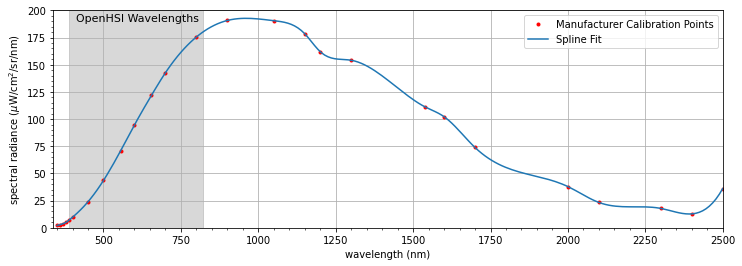

In [ ]:
fig = sb.update_intsphere_fit()

In [ ]:
#sb.dump() # resave the settings and calibration files

## Integrating Sphere data

4D datacube with coordinates of cross-track, wavelength, exposure, and luminance.

Needs testing!

In [ ]:

exposures  = np.array([0,5,8,10,15,20,50])
luminances = np.array([0,10_000,20_000,30_000,40_000,0])

#@patch
def update_intsphere_cube(self:SettingsBuilderMixin,exposures:np.array,luminances:np.array):
    
    shape = (np.ptp(self.settings["row_slice"]),self.settings["resolution"][1],len(exposures),len(luminances))
    
    lum_buff = CircArrayBuffer(shape[:3],axis=2,dtype=np.int32)
    rad_ref  = CircArrayBuffer(shape,axis=3,dtype=np.int32)
    
    mb = master_bar(range(len(luminances)))
    for i in mb:
        mb.main_bar.comment = f"Luminance = {luminances[i]} Cd/m^2"
        input(f"\rLuminance = {luminances[i]} Cd/m^2. Press enter key when ready...")
        
        for j in progress_bar(range(len(exposures)), parent=mb):
            mb.child.comment = f"exposure = {exposures[j]} ms"
            #self.set_exposure(exposures[j])
            self.start_cam()
            lum_buff.put( self.crop(self.get_img()) )
            self.stop_cam()
        
        rad_ref.put( lum_buff.data )
        mb.write(f"Finished collecting at luminance {luminances[i]} Cd/m^2.")
    
    return xr.Dataset(data_vars=dict(datacube=(["cross_track","wavelength_index","exposure","luminance"],rad_ref.data)),
                                             coords=dict(cross_track=(["cross_track"],np.arange(shape[0])),
                                                      wavelength_index=(["wavelength_index"],np.arange(shape[1])),
                                                      exposure=(["exposure"],exposures),
                                                      luminance=(["luminance"],luminances)), attrs={})

test = update_intsphere_cube(sb,exposures,luminances)

Luminance = 0 Cd/m^2. Press enter key when ready... 
Luminance = 10000 Cd/m^2. Press enter key when ready... 
Luminance = 20000 Cd/m^2. Press enter key when ready... 
Luminance = 30000 Cd/m^2. Press enter key when ready... 
Luminance = 40000 Cd/m^2. Press enter key when ready... 
Luminance = 0 Cd/m^2. Press enter key when ready... 


In [ ]:
test

<xarray.Dataset>
Dimensions:           (cross_track: 450, exposure: 7, luminance: 6, wavelength_index: 2064)
Coordinates:
  * cross_track       (cross_track) int64 0 1 2 3 4 5 ... 445 446 447 448 449
  * wavelength_index  (wavelength_index) int64 0 1 2 3 4 ... 2060 2061 2062 2063
  * exposure          (exposure) int64 0 5 8 10 15 20 50
  * luminance         (luminance) int64 0 10000 20000 30000 40000 0
Data variables:
    datacube          (cross_track, wavelength_index, exposure, luminance) int32 2 ... 0

Ignore the duplicated luminance value of 0 to plot. It is not entirely dark since SimulatedCamera is generating random RGB numbers (and applying a red, green, and blue envelope). 

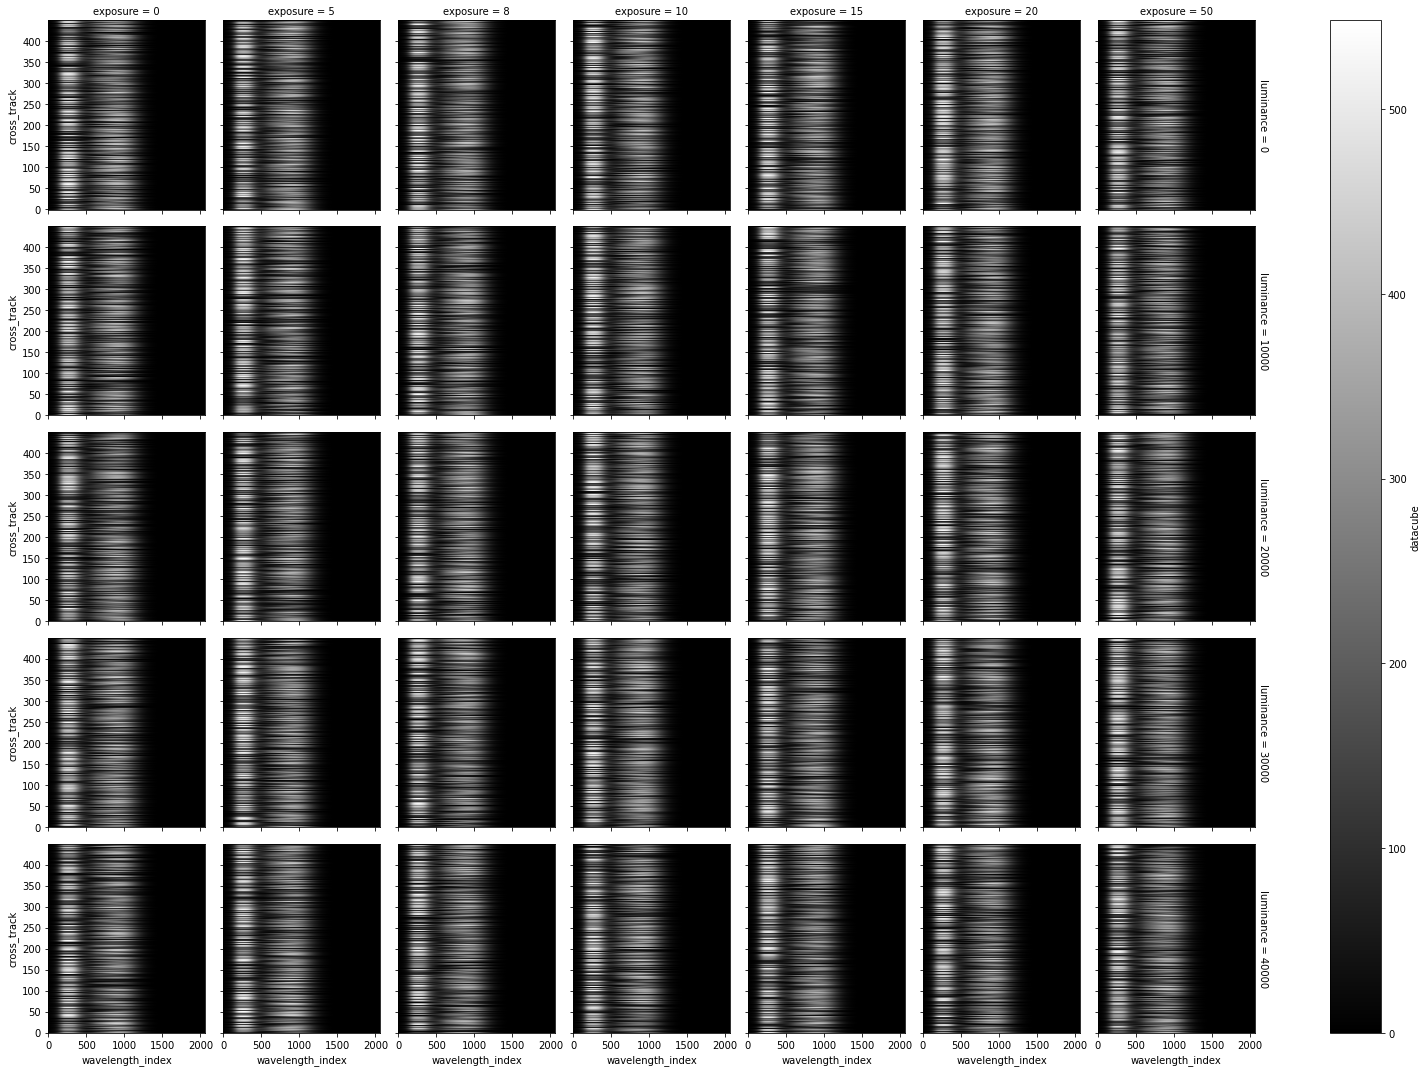

In [ ]:
test.datacube[...,:-1].plot(y="cross_track", x="wavelength_index", col="exposure", row="luminance",cmap="gray")

In [ ]:
f"rad_ref is {test.datacube.size/1024/1024 *4:.2f} MB"

'rad_ref is 148.81 MB'